In this notebook we are going to take age group data from a California (by county) demographics dataset and compare them with Covid case counts per month of those same age groups.  Were any age groups impacted disproportionately given their percentage of cases and percentage of the population?

In [1]:
# import the various modules needed
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import numpy as np

DEMOGRAPHICS DATA: Pull in the dataset.  Get columns required for analysis.  Calculate additional quantity columns needed for each age group.  Get population counts for each age group, for population total.  Get percentages of each age group of total population.

In [2]:
# Read demographics data into dataframe and drop last line containing NaN
demographfile = "../../Resources/Clean/ca_county_demographic_data-20210804.csv"
demograph_df = pd.read_csv(demographfile).dropna(subset=["FIPS Code"])
demograph_df.tail()

,FIPS Code,County,Cumulative Cases (2020-02-01 - 2021-31-07),Cumulative Deaths (2020-02-01 - 2021-31-07),Cumulative Deaths /Cases (calculated by EK),Cases per capita (calculated by EK),Deaths per capita (calculated by EK),Total Population,Population density (people per sq. mile):\t,Pop % Less Than 18 Years of Age,...,# Uninsured (Adults),% Uninsured (Adults),% Uninsured (Adults) Error Margin,# Uninsured (Children),% Uninsured (Children),% Uninsured (Children) Error Margin,% Frequent Mental Distress,% Frequent Mental Distress Error Margin,% Frequent Physical Distress,% Frequent Physical Distress Error Margin
53,6107,Tulare,50626,854,0.016869,0.108594,0.001832,"466,195",96.63,30.5,...,"31,986",12,11-13%,"4,593",3,2-4%,16,14-17%,17,16-18%
54,6109,Tuolumne,4522,59,0.013047,0.083006,0.001083,"54,478",24.53,16.8,...,"2,072",7,6-9%,275,3,2-4%,14,13-16%,13,12-15%
55,6111,Ventura,84114,1036,0.012317,0.099425,0.001225,"846,006",459.17,22.6,...,"61,204",12,11-13%,"6,301",3,2-4%,12,11-14%,12,11-14%
56,6113,Yolo,15069,215,0.014268,0.068340,0.000975,"220,500",217.3,20.8,...,"11,368",8,7-9%,"1,323",3,2-4%,13,12-14%,13,11-14%
57,6115,Yuba,6730,49,0.007281,0.085549,0.000623,"78,668",124.47,27.4,...,"4,632",10,9-12%,607,3,2-4%,15,14-16%,15,14-16%


In [3]:
# Fix the data types in demographics dataframe
demograph_df["Total Population"] = demograph_df["Total Population"].str.replace(',', '').astype(float)
# Get age related subset of columns needed for analysis
demo_age_df = demograph_df[["County","Total Population","Pop % 65 and Over", "Pop % Less Than 18 Years of Age"]].copy()
demo_age_df.head()

,County,Total Population,Pop % 65 and Over,Pop % Less Than 18 Years of Age
0,Alameda,1671329.0,14.3,20.3
1,Alpine,1129.0,26.4,17.7
2,Amador,39752.0,27.5,15.1
3,Butte,219186.0,18.4,20.3
4,Calaveras,45905.0,28.0,17.1


In [4]:
# Extrapolate population quantity totals in each county for age groups, save in age groups df
pop_total_count  = demo_age_df["Total Population"]
pop_pct_under_18 = demo_age_df["Pop % Less Than 18 Years of Age"]
pop_pct_over_65  = demo_age_df["Pop % 65 and Over"]
demo_age_df["Pop # 0 to 17"]  = pop_total_count * pop_pct_under_18 / 100
demo_age_df["Pop # 18 to 64"] = pop_total_count * (100 - pop_pct_under_18 - pop_pct_over_65) / 100
demo_age_df["Pop # 65 to up"] = pop_total_count * pop_pct_over_65 / 100
demo_age_df.head()

,County,Total Population,Pop % 65 and Over,Pop % Less Than 18 Years of Age,Pop # 0 to 17,Pop # 18 to 64,Pop # 65 to up
0,Alameda,1671329.0,14.3,20.3,339279.787,1093049.166,239000.047
1,Alpine,1129.0,26.4,17.7,199.833,631.111,298.056
2,Amador,39752.0,27.5,15.1,6002.552,22817.648,10931.800
3,Butte,219186.0,18.4,20.3,44494.758,134361.018,40330.224
4,Calaveras,45905.0,28.0,17.1,7849.755,25201.845,12853.400


In [5]:
# Get sum population per age group and total population for California from demographics
demo_age_summary = demo_age_df[["Total Population", "Pop # 0 to 17", "Pop # 18 to 64", "Pop # 65 to up"]].round().sum()
demo_age_summary

Total Population    39512223.0
Pop # 0 to 17        8898202.0
Pop # 18 to 64      24774548.0
Pop # 65 to up       5839475.0
dtype: float64

In [6]:
# Calculate percent of total California population that each age group represents
## Give shorter friendlier names for specific columns
pop_CA_0_17 = demo_age_summary["Pop # 0 to 17"]
pop_CA_18_64 = demo_age_summary["Pop # 18 to 64"]
pop_CA_65_up = demo_age_summary["Pop # 65 to up"]
pop_CA_total = demo_age_summary["Total Population"]

## Calculate and print population percentages for each age group for California
pop_pct_CA_0_17  = pop_CA_0_17  * 100 / pop_CA_total
pop_pct_CA_18_64 = pop_CA_18_64 * 100 / pop_CA_total
pop_pct_CA_65_up = pop_CA_65_up * 100 / pop_CA_total
pop_pct_CA_0_17, pop_pct_CA_18_64, pop_pct_CA_65_up

(22.520124974998243, 62.70097230419053, 14.778907782536052)

COVID CASES DATA: Pull in the cleaned dataset.  Contains cases by row of each individual case reported in California by date, sex, age group, county, etc. Get columns required for analysis. Give each age group its own dataframe of data.

In [7]:
# Read in the monthly individual cases data from California into dataframe
cases_file = "../../Resources/Clean/ca_data_df.csv"
cases_df = pd.read_csv(cases_file)
cases_df["age_group"].value_counts()

18 to 49 years    2130719
50 to 64 years     702472
0 - 17 years       484140
65+ years          389319
Unknown              8377
Name: age_group, dtype: int64

In [8]:
# Create a subset of columns from the cases for our age_group analysis
cases_agegroup_df = cases_df[["case_month", "age_group"]].copy()
cases_agegroup_df.head()

,case_month,age_group
0,2020-12,0 - 17 years
1,2021-03,0 - 17 years
2,2021-01,0 - 17 years
3,2020-11,18 to 49 years
4,2021-01,65+ years


In [9]:
# Group the cases by case_month then count the cases.  One df per age group, one df for totals
## Define Filters
age_group_0_17  = (cases_agegroup_df["age_group"] == "0 - 17 years")
age_group_18_49 = (cases_agegroup_df["age_group"] == "18 to 49 years")
age_group_50_64 = (cases_agegroup_df["age_group"] == "50 to 64 years")
age_group_18_64 = age_group_18_49 | age_group_50_64
age_group_65_up = (cases_agegroup_df["age_group"] == "65+ years")
age_group_all   = age_group_0_17 | age_group_18_49 | age_group_50_64 | age_group_65_up

## Group by case_month and then count cases.  Include one for grand total
cases_0_17_df   = (cases_agegroup_df
                   .loc[age_group_0_17]
#                    .rename(columns={"age_group": "0 to 17"})
                   .groupby(by="case_month")
                   .count()
                   .copy()
                  )
cases_18_49_df   = (cases_agegroup_df
                   .loc[age_group_18_49]
#                    .rename(columns={"age_group": "18 to 49"})
                   .groupby(by="case_month")
                   .count()
                   .copy()
                  )
cases_50_64_df   = (cases_agegroup_df
                   .loc[age_group_50_64]
#                    .rename(columns={"age_group": "50 to 64"})
                   .groupby(by="case_month")
                   .count()
                   .copy()
                  )
cases_18_64_df   = (cases_agegroup_df
                   .loc[age_group_18_64]
#                    .rename(columns={"age_group": "18 to 64"})
                   .groupby(by="case_month")
                   .count()
                   .copy()
                  )
cases_65_up_df   = (cases_agegroup_df
                   .loc[age_group_65_up]
#                    .rename(columns={"age_group": "65 and up"})
                   .groupby(by="case_month")
                   .count()
                   .copy()
                  )
cases_total_df   = (cases_agegroup_df
                    .loc[age_group_all]
#                    .rename(columns={"age_group": "all ages"})
                   .groupby(by="case_month")
                   .count()
                   .copy()
                  )

In [10]:
# Calculate percent of total cases per month that each age group comprised
pct_monthly_0_17  = (cases_0_17_df * 100 / cases_total_df).copy()
pct_monthly_18_49 = (cases_18_49_df * 100 / cases_total_df).copy()
pct_monthly_18_64 = (cases_18_64_df * 100 / cases_total_df).copy()
pct_monthly_50_64 = (cases_50_64_df * 100 / cases_total_df).copy()
pct_monthly_65_up = (cases_65_up_df * 100 / cases_total_df).copy()
pct_monthly_50_64.head()

,age_group
case_month,
2020-01,19.369369
2020-02,28.787879
2020-03,28.048250
2020-04,24.116912
2020-05,20.878698


In [11]:
# Rename the "age_group" column for the affected dataframes after doing the pct math
cases_0_17_df     = cases_0_17_df.rename(columns={"age_group": "0 to 17"})
cases_18_49_df    = cases_18_49_df.rename(columns={"age_group": "18 to 49"})
cases_18_64_df    = cases_18_64_df.rename(columns={"age_group": "18 to 64"})
cases_50_64_df    = cases_50_64_df.rename(columns={"age_group": "50 to 64"})
cases_65_up_df    = cases_65_up_df.rename(columns={"age_group": "65 and up"})
cases_total_df    = cases_total_df.rename(columns={"age_group": "all ages"})
pct_monthly_0_17  = pct_monthly_0_17.rename(columns={"age_group": "0 to 17"})
pct_monthly_18_49 = pct_monthly_18_49.rename(columns={"age_group": "18 to 49"})
pct_monthly_18_64 = pct_monthly_18_64.rename(columns={"age_group": "18 to 64"})
pct_monthly_50_64 = pct_monthly_50_64.rename(columns={"age_group": "50 to 64"})
pct_monthly_65_up = pct_monthly_65_up.rename(columns={"age_group": "65 and up"})

In [12]:
# One frame for all case counts 3 groups
frames = [cases_18_64_df, cases_0_17_df, cases_65_up_df]
all_ages_cases_df = pd.concat(frames, axis=1).fillna(0).copy()
all_ages_cases_df.head()

,18 to 64,0 to 17,65 and up
case_month,,,
2020-01,195,12.0,15
2020-02,213,0.0,51
2020-03,14554,155.0,3695
2020-04,33930,1855.0,9822
2020-05,54386,5805.0,9890


In [13]:
# One frame for all case counts 4 groups
frames = [cases_18_49_df, cases_0_17_df, cases_50_64_df, cases_65_up_df]
all_ages_4_groups_df = pd.concat(frames, axis=1).fillna(0).copy()
all_ages_4_groups_df.head()

,18 to 49,0 to 17,50 to 64,65 and up
case_month,,,,
2020-01,152,12.0,43,15
2020-02,137,0.0,76,51
2020-03,9392,155.0,5162,3695
2020-04,22931,1855.0,10999,9822
2020-05,39754,5805.0,14632,9890


In [14]:
## One dataframe with monthly percentage of the 3 age groups in demographics. Case month as index
frames = [pct_monthly_18_64, pct_monthly_0_17, pct_monthly_65_up]
all_ages_pct_df = pd.concat(frames, axis=1).fillna(0).copy()
all_ages_pct_df.head()

,18 to 64,0 to 17,65 and up
case_month,,,
2020-01,87.837838,5.405405,6.756757
2020-02,80.681818,0.000000,19.318182
2020-03,79.080635,0.842208,20.077157
2020-04,74.396474,4.067358,21.536168
2020-05,77.604486,8.283272,14.112242


In [15]:
## One dataframe with monthly percentage of the 4 age groups in cases frame. Case month as index
frames = [pct_monthly_18_49, pct_monthly_50_64, pct_monthly_0_17, pct_monthly_65_up]
all_ages_pct_4_df = pd.concat(frames, axis=1).fillna(0).copy()
all_ages_pct_4_df.head()

,18 to 49,50 to 64,0 to 17,65 and up
case_month,,,,
2020-01,68.468468,19.369369,5.405405,6.756757
2020-02,51.893939,28.787879,0.000000,19.318182
2020-03,51.032384,28.048250,0.842208,20.077157
2020-04,50.279562,24.116912,4.067358,21.536168
2020-05,56.725789,20.878698,8.283272,14.112242


In [16]:
# Reorder the age groups sequentially so they plot sequentially in each graph
all_ages_cases_df = all_ages_cases_df[["0 to 17", "18 to 64", "65 and up"]]
all_ages_4_groups_df = all_ages_4_groups_df[["0 to 17", "18 to 49", "50 to 64", "65 and up"]]
all_ages_pct_df = all_ages_pct_df[["0 to 17", "18 to 64", "65 and up"]]
all_ages_pct_4_df = all_ages_pct_4_df[["0 to 17", "18 to 49", "50 to 64", "65 and up"]]

PLOTS: Plot monthly counts of cases per age group, percentage of cases vs percentage of population, stacked counts of cases per age group

In [17]:
# Identify location of output images
output_images = "../../Images"

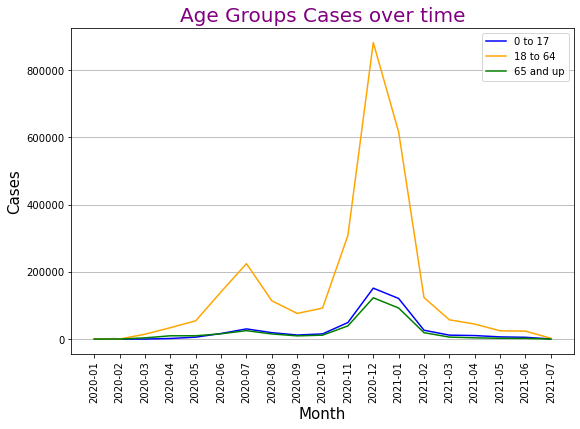

In [18]:
plt.figure(figsize=(9,6))
plt.plot(all_ages_cases_df.index, all_ages_cases_df["0 to 17"], color="blue")
plt.plot(all_ages_cases_df.index, all_ages_cases_df["18 to 64"], color="orange")
plt.plot(all_ages_cases_df.index, all_ages_cases_df["65 and up"], color="green")
plt.title("Age Groups Cases over time", color="purple", fontsize=20)
plt.xticks(rotation="vertical")
plt.xlabel("Month", fontsize=15)
plt.ylabel("Cases", fontsize=15)
plt.legend(["0 to 17", "18 to 64", "65 and up"],loc="best")
plt.grid(axis="y")
plt.savefig(f"{output_images}/age_groups_monthly_counts.png")
plt.show()

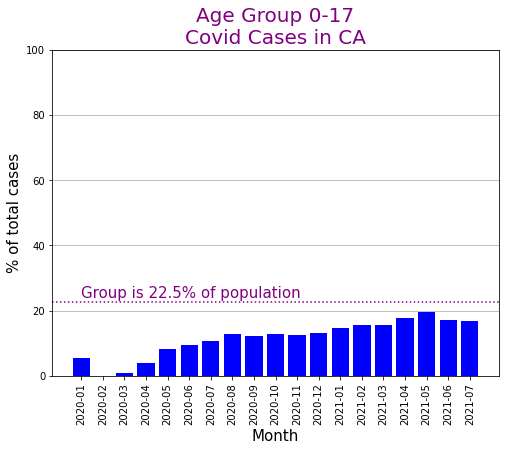

In [19]:
# Plot monthly percentage of total cases for 0-17
plt.figure(figsize=(8,6))
plt.bar(pct_monthly_0_17.index, pct_monthly_0_17["0 to 17"], color="blue")
plt.title(f"Age Group 0-17\nCovid Cases in CA", color="purple", fontsize=20)
plt.xticks(rotation="vertical")
plt.xlabel("Month", fontsize=15)
plt.ylabel("% of total cases", fontsize=15)
plt.ylim(0, 100)
plt.grid(axis="y")
plt.axhline(y = pop_pct_CA_0_17,  linestyle = ":", color="purple")
plt.annotate(f"Group is {round(pop_pct_CA_0_17,1)}% of population",(0,24),fontsize=15,color="purple")
plt.savefig(f"{output_images}/age_group_0_17_cases.png")
plt.show()

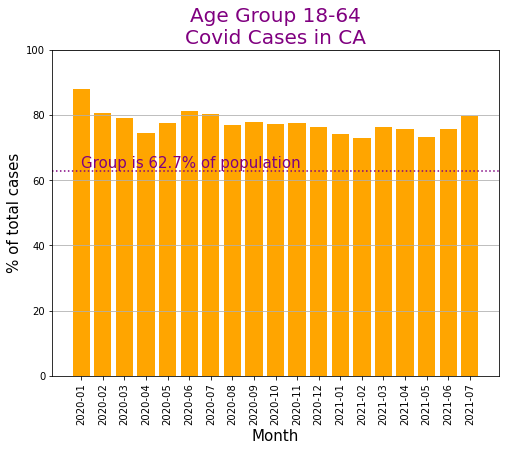

In [20]:
# Plot monthly percentage of total cases for 18-64
plt.figure(figsize=(8,6))
plt.bar(pct_monthly_18_64.index, pct_monthly_18_64["18 to 64"], color="orange")
plt.title(f"Age Group 18-64\nCovid Cases in CA", color="purple", fontsize=20)
plt.xticks(rotation="vertical")
plt.xlabel("Month", fontsize=15)
plt.ylabel("% of total cases", fontsize=15)
plt.ylim(0, 100)
plt.grid(axis="y")
plt.axhline(y = pop_pct_CA_18_64,  linestyle = ":", color="purple")
plt.annotate(f"Group is {round(pop_pct_CA_18_64,1)}% of population",(0,64),fontsize=15,color="purple")
plt.savefig(f"{output_images}/age_group_18_64_cases.png")
plt.show()

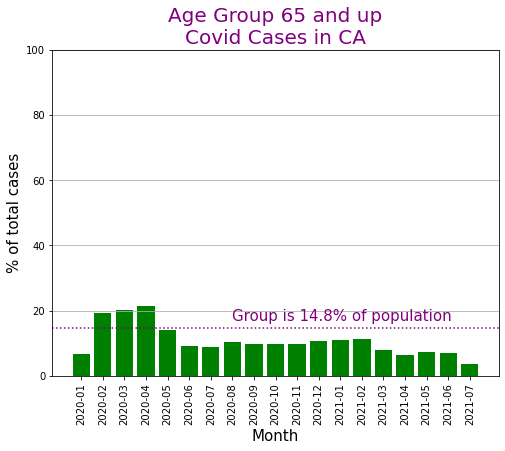

In [21]:
# Plot monthly percentage of total cases for 65 and up
plt.figure(figsize=(8,6))
plt.bar(pct_monthly_65_up.index, pct_monthly_65_up["65 and up"], color="green")
plt.title(f"Age Group 65 and up\nCovid Cases in CA", color="purple", fontsize=20)
plt.xticks(rotation="vertical")
plt.xlabel("Month", fontsize=15)
plt.ylabel("% of total cases", fontsize=15)
plt.ylim(0, 100)
plt.grid(axis="y")
plt.axhline(y = pop_pct_CA_65_up,  linestyle = ":", color="purple")
plt.annotate(f"Group is {round(pop_pct_CA_65_up,1)}% of population",(7,17),fontsize=15,color="purple")
plt.savefig(f"{output_images}/age_group_65_up_cases.png")
plt.show()

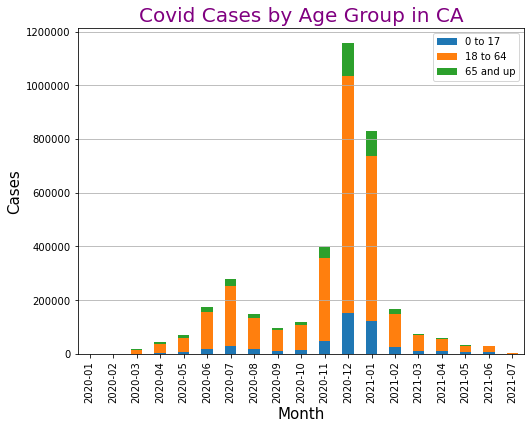

In [22]:
# Plot stacked bar chart of cases by age group monthly (cases data + demographic data)
all_ages_cases_df.plot.bar(stacked=True, figsize=(8,6))
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title("Covid Cases by Age Group in CA", fontsize=20, color="purple")
plt.xlabel("Month", fontsize=15)
plt.ylabel("Cases", fontsize=15)
plt.grid(axis="y")
plt.savefig(f"{output_images}/age_groups_total_stacked_bar.png")
plt.show()

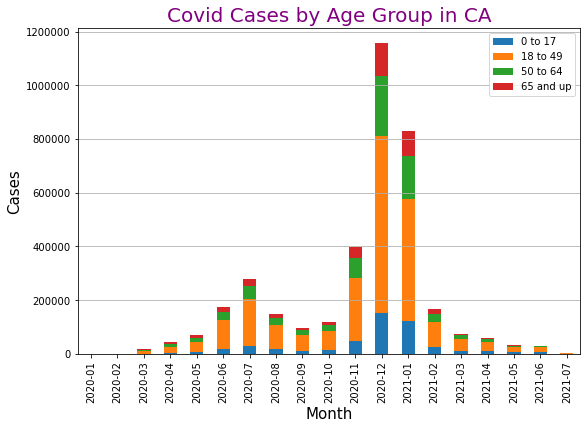

In [23]:
# Plot stacked bar chart of cases by age group monthly (cases data only, 4 age groups)
all_ages_4_groups_df.plot.bar(stacked=True, figsize=(9,6))
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title("Covid Cases by Age Group in CA", fontsize=20, color="purple")
plt.xlabel("Month", fontsize=15)
plt.ylabel("Cases", fontsize=15)
plt.grid(axis="y")
plt.savefig(f"{output_images}/age_groups_total_4_stacked_bar.png")
plt.show()

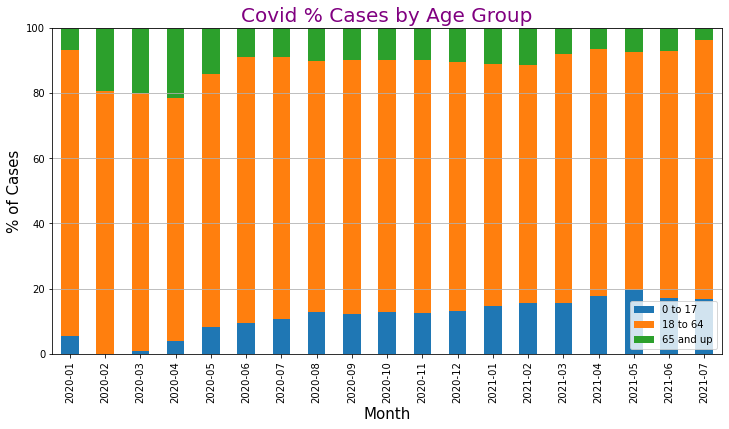

In [24]:
# Unstacked bar chart showing percentage cases by 3 age groups per month
all_ages_pct_df.plot.bar(stacked=True, figsize=(12,6))
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title("Covid % Cases by Age Group", fontsize=20, color="purple")
plt.xlabel("Month", fontsize=15)
plt.ylim(0,100)
plt.ylabel("% of Cases", fontsize=15)
plt.grid(axis="y")
plt.savefig(f"{output_images}/age_groups_pct_3_stacked_bar.png")
plt.show()

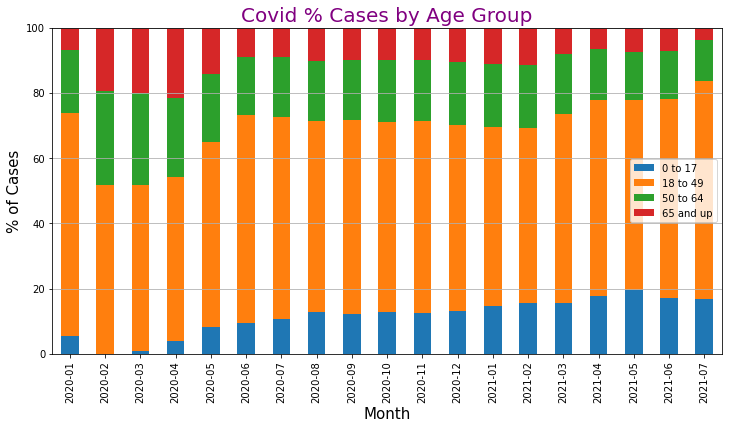

In [25]:
# Unstacked bar chart showing percentage cases by 4 age groups per month
all_ages_pct_4_df.plot.bar(stacked=True, figsize=(12,6))
plt.title("Covid % Cases by Age Group", fontsize=20, color="purple")
plt.xlabel("Month", fontsize=15)
plt.ylim(0,100)
plt.ylabel("% of Cases", fontsize=15)
plt.grid(axis="y")
plt.savefig(f"{output_images}/age_groups_pct_4_stacked_bar.png")
plt.show()